### CODE SUMMARY

1. CALCULATE THE ANGLE BETWEEN EACH NEUTRINO AND EACH PULSAR USING HAVERSINE FORMULA
2. IF THE ABSOLUTE VALUE OF THE ANGLE BETWEEN NEUTRINO AND PULSAR < ANG_ERR OF THAT NEUTRINO:

            STORE THE DETAILS OF THE NEUTRINO AND THAT PULSAR IN A DATABASE
3. PLOT THE SELECTED NEUTRINO PULSAR PAIRS IN A GRAPH

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
 "IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]

In [3]:
file = filenames[0]
f = open(os.path.join(path, file), 'r')

lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []

In [4]:
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()

In [5]:
icdata = pd.DataFrame(content, columns=column)

In [6]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.37911273,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.38662244,5.17,0.62,75.024,-13.371,349.100,76.646
2,54562.38789162,3.92,0.56,97.501,11.290,327.060,101.291
3,54562.39267689,5.57,1.13,305.857,-33.932,120.413,56.090
4,54562.40477593,5.80,1.11,143.516,-38.279,287.171,51.684
...,...,...,...,...,...,...,...
1134445,58307.96110988,5.14,0.20,221.246,-59.959,141.239,29.956
1134446,58307.96266638,2.94,1.23,191.547,4.415,171.627,94.312
1134447,58307.96355617,2.88,0.30,308.127,42.543,55.437,132.606
1134448,58307.96397167,2.98,0.21,332.199,44.720,31.489,134.811


In [7]:

f = open("10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()

for line in lines[:]:
    content.append(line.split())

#the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]

In [8]:
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)
mspdata

,NAME,Gl,Gb,RAJD,DECJD,P0,F0,DIST
0,J0023+0923,111.383,-52.849,5.82032291,9.38996121,0.003050203104754390,327.8470205611185,1.818
1,J0024-7204aa,305.895,-44.889,6.02363,-72.08128,0.00184,543.478261,2.688
2,J0024-7204ab,305.891,-44.891,6.034006,-72.0798894,0.0037046394947985,269.93179806134,2.540
3,J0024-7204ac,305.898,-44.902,6.02363,-72.06806,0.00274,364.963504,4.690
4,J0024-7204ad,305.898,-44.902,6.02363,-72.06806,0.00374,267.379679,4.690
...,...,...,...,...,...,...,...,...
436,J2310-0555,69.702,-57.907,347.526792,-5.92664,0.0026125867919415,382.76240356282,1.556
437,J2317+1439,91.361,-42.360,349.288484923,14.65868362,0.0034452510723611,290.25460815391,1.667
438,J2322+2057,96.515,-37.310,350.5930632,20.9507437,0.0048084282894641,207.96816335831,1.011
439,J2322-2650,28.637,-70.228,350.64433350,-26.84953253,0.00346309917908790,288.758695112907,0.227


243 EXTRA 0S ARE ADDED AT THE END OF ALL THE IC DATA CONTAINING ARRAYS TO MAKE THEIR LENGTH A MULTIPLE OF 441

AS LENGTH OF THE PULSAR DATA ARRAYS IS 441

In [9]:
icra = [float(i) for i in icdata['RA[deg]']]
icdec = [float(i) for i in icdata['Dec[deg]']]
icangerr = [float(i) for i in icdata['AngErr[deg]']]
icangerr.extend([0]*243)
icra.extend([0]*(243))
icdec.extend([0]*(243))
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
canger = [0.5 * (1-np.cos(np.deg2rad(i))) for i in icangerr]

VECTORIZED HAVERSINE METHOD THAT RETURNS THE ANGLE BETWEEN 2 POINTS GIVEN THEIR COORDINATES IN RA[deg] AND DEC[deg]

In [10]:
#@numba.jit(nopython=True)
#@numba.cuda.jit(nopython=True)

def hvocos(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)
    #a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))
    a = np.abs(np.subtract(np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon))), cos5 * np.ones(len(lat1))))

    return a

THE NEXT CELL CALCULATES THE HAVERSINE ANGLES (IN BATCHES) AND IF THAT it satisfies $|cos(\theta)-cos(5)|  < 0.5 x (1-cos X)$ 

Then the variable bgdcount (which counts the #background events) is increased by 1

In [11]:
lg = int(len(icra)/len(msra))
p = len(msra)
background = []
bgcount = 0
lo = []
la = []
cos5 = np.cos(np.deg2rad(5))
for k in range(lg):
    ilo = icra[k * p  :p * k + p]
    ila = icdec[k * p  :p * k + p]
    lo =[]
    la = []
    
    for j in range(p):#441
                lo = [msra[(i + j)%p] for i in range(0,p)]
                la = [msdec[(i + j)%p] for i in range(0,p)]
                hvscos = hvocos(ilo, ila, lo, la)
                lo = []
                la = []
                for l in range(p):
                    if hvscos[l] < canger[l]:
                        #bgcount+=1
                        background.append([int(k*p+j),int(l)])
                    #else:
                      #  signal.append([k,j,l, hvscos[l], icangerr[k*p + l]])
                    


In [12]:
dr = pd.DataFrame(background)

#dr = dr.reset_index().drop('index', axis=1)
c = ['idnu',"idpsr"]
dr.columns = c
dr = dr[dr['idnu'] <= 1134207]

In [13]:
ic = pd.concat([icdata.iloc[i] for i in dr.idnu.values], axis=1).T
ic = ic.drop(["MJD[days]", "Azimuth[deg]", "Zenith[deg]"], axis=1)
ic = ic.sort_index()
ic = ic.reset_index()
ic

,index,log10(E/GeV),AngErr[deg],RA[deg],Dec[deg]
0,118,5.51,0.48,29.919,-18.508
1,227,4.50,1.02,244.082,-7.583
2,238,5.29,1.25,247.112,-10.847
3,276,5.50,1.03,172.172,-27.323
4,315,3.73,0.47,346.301,-3.857
...,...,...,...,...,...
31086,1134128,4.83,0.34,18.430,-24.410
31087,1134129,3.05,0.27,112.530,-5.533
31088,1134163,3.28,1.64,31.829,18.966
31089,1134164,4.19,0.20,197.108,-17.302


In [15]:
ms = pd.concat([mspdata.iloc[i] for i in dr.idpsr.values], axis=1).T
ms = ms.drop(['Gl','Gb','F0', 'NAME'], axis=1)
ms = ms.sort_index()
ms = ms.reset_index()
ms

,index,RAJD,DECJD,P0,DIST
0,0,5.82032291,9.38996121,0.003050203104754390,1.818
1,0,5.82032291,9.38996121,0.003050203104754390,1.818
2,0,5.82032291,9.38996121,0.003050203104754390,1.818
3,0,5.82032291,9.38996121,0.003050203104754390,1.818
4,0,5.82032291,9.38996121,0.003050203104754390,1.818
...,...,...,...,...,...
31086,439,350.64433350,-26.84953253,0.00346309917908790,0.227
31087,440,354.91142,-5.551478,0.00288422674154723,1.100
31088,440,354.91142,-5.551478,0.00288422674154723,1.100
31089,440,354.91142,-5.551478,0.00288422674154723,1.100


In [16]:
a2 = pd.concat([ic, ms],axis=1)
a2.dropna(inplace=True)
#REMOVING THE EXCESS ENTRIES AS WE ADDED 243 0'S
#a2 = a2[a2['index'] <= 1134207]
dr = []
a2 = a2.drop("DIST", axis=1)

In [41]:
c = ['nu_index','log10(E/GeV)','AngErr[deg]', 'nuRA[deg]', 'nuDec[deg]', 'psrmatch', 'psrRA[deg]','psrDec[deg]','p0']
a2.columns = c
a2.to_csv("neutrino-pulsar-background5deg.csv")
a2

,nu_index,log10(E/GeV),AngErr[deg],nuRA[deg],nuDec[deg],psrmatch,psrRA[deg],psrDec[deg],p0
0,118,5.51,0.48,29.919,-18.508,0,5.82032291,9.38996121,0.003050203104754390
1,227,4.50,1.02,244.082,-7.583,0,5.82032291,9.38996121,0.003050203104754390
2,238,5.29,1.25,247.112,-10.847,0,5.82032291,9.38996121,0.003050203104754390
3,276,5.50,1.03,172.172,-27.323,0,5.82032291,9.38996121,0.003050203104754390
4,315,3.73,0.47,346.301,-3.857,0,5.82032291,9.38996121,0.003050203104754390
...,...,...,...,...,...,...,...,...,...
31086,1134128,4.83,0.34,18.430,-24.410,439,350.64433350,-26.84953253,0.00346309917908790
31087,1134129,3.05,0.27,112.530,-5.533,440,354.91142,-5.551478,0.00288422674154723
31088,1134163,3.28,1.64,31.829,18.966,440,354.91142,-5.551478,0.00288422674154723
31089,1134164,4.19,0.20,197.108,-17.302,440,354.91142,-5.551478,0.00288422674154723


ALL THE PULSARS AND THE NEUTRINOS WHOSE NEIGHBOURHOOD CONTAINS THE PULSARS, ARE PLOTTED IN THE FOLLOWING GRAPH

In [18]:
fic = list(set(a2.nu_index.values))
fms = [int(i) for i in a2.psrmatch.values]


In [26]:
fms = list(set(fms))


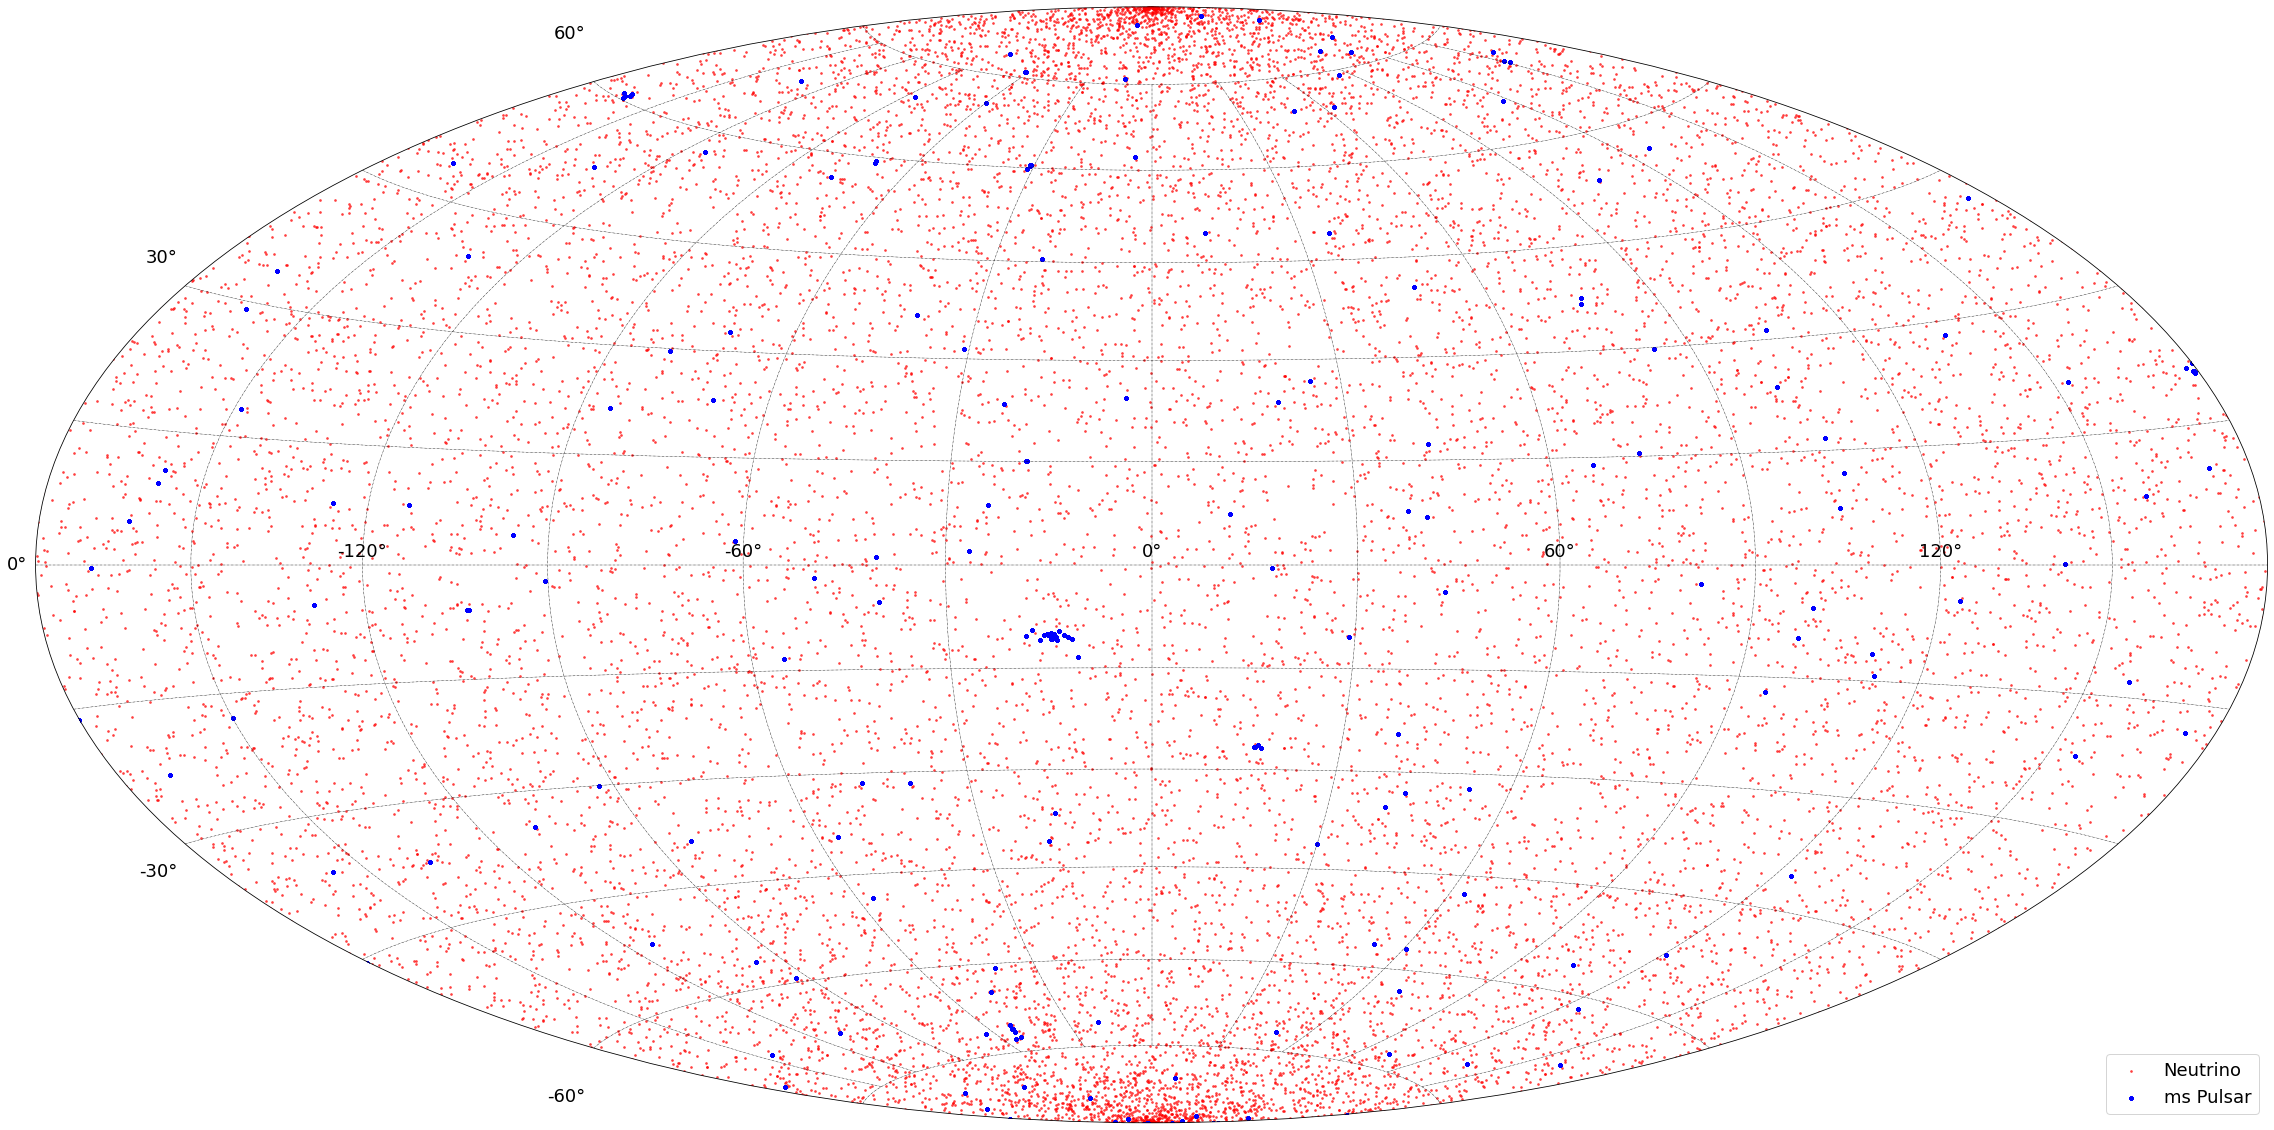

In [40]:
fig = plt.figure(figsize=(40,24))
plt.rcParams.update({'font.size': 18})
ax2 = plt.subplot(111,projection='hammer')
ax2.scatter([icra[i] for i in fic], [icdec[i] for i in fic],marker='.',color='r', s = 12,alpha=0.6, label='Neutrino')
ax2.scatter([[msra[i] for i in fms] for i in fms], [[msdec[i] for i in fms] for i in fms],marker='P',color='b', s = 17, label='ms Pulsar')
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2, 2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='black', lw=0.4, ls = '-.')
plt.legend()
#plt.show()
plt.savefig("output2c.png", facecolor='w')